In [1]:
# Imports
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm.auto import tqdm
import numpy as np
from datetime import datetime

# Local imports
from data.dataset import create_dataloaders
from models.efficientnet import create_efficientnet_b0
from utils.training import (
    calculate_class_weights,
    EarlyStopping,
    MetricsCalculator,
    TensorBoardLogger,
    save_checkpoint,
    load_checkpoint
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu126
CUDA available: True
GPU: NVIDIA GeForce RTX 3080 Laptop GPU


## 1. Configuration

In [2]:
# Configuration
class Config:
    # Paths
    DATA_DIR = project_root.parent / 'data' / 'processed' 
    CHECKPOINT_DIR = project_root.parent / 'models_exported'
    LOG_DIR = project_root.parent / 'runs' / 'efficientnet'
    
    # Model
    NUM_CLASSES = 38
    PRETRAINED = True
    DROPOUT = 0.3
    
    # Training - Phase 1 (Warmup)
    WARMUP_EPOCHS = 5
    WARMUP_LR = 1e-3
    
    # Training - Phase 2 (Fine-tuning)
    FINETUNE_EPOCHS = 25
    BACKBONE_LR = 1e-4
    CLASSIFIER_LR = 1e-3
    UNFREEZE_BLOCKS = 3
    
    # Scheduler
    T_0 = 5  # First restart period
    T_MULT = 2  # Period multiplier
    
    # Data
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    IMAGE_SIZE = 224
    
    # Training
    EARLY_STOPPING_PATIENCE = 5
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    SEED = 42

config = Config()

# Create directories
config.CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
config.LOG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {config.DATA_DIR}")
print(f"Checkpoint directory: {config.CHECKPOINT_DIR}")
print(f"Device: {config.DEVICE}")

Data directory: d:\Repos\plant-disease-project\data\processed
Checkpoint directory: d:\Repos\plant-disease-project\models_exported
Device: cuda


In [3]:
# Set random seeds for reproducibility
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.SEED)
print(f"Random seed set to {config.SEED}")

Random seed set to 42


## 2. Load Data

In [4]:
# Create datasets first
from data.dataset import create_datasets

train_dataset, val_dataset, test_dataset = create_datasets(
    data_dir=config.DATA_DIR,
    image_size=config.IMAGE_SIZE
)

# Create data loaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS
)

# Get class names from the training dataset
class_names = train_dataset.classes

print(f"Number of classes: {len(class_names)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Number of classes: 38
Training samples: 43429
Validation samples: 5417
Training batches: 1357
Validation batches: 170


In [5]:
# Calculate class weights for handling class imbalance
class_weights = calculate_class_weights(train_loader.dataset)
class_weights = class_weights.to(config.DEVICE)

print(f"Class weights shape: {class_weights.shape}")
print(f"Min weight: {class_weights.min():.4f}")
print(f"Max weight: {class_weights.max():.4f}")

Class weights shape: torch.Size([38])
Min weight: 0.2594
Max weight: 9.4452
Min weight: 0.2594
Max weight: 9.4452


## 3. Create Model

In [6]:
# Create model
model = create_efficientnet_b0(
    num_classes=config.NUM_CLASSES,
    pretrained=config.PRETRAINED,
    dropout_rate=config.DROPOUT
)
model = model.to(config.DEVICE)

print(f"Model created: EfficientNet-B0")
print(f"Total parameters: {model.get_num_params(trainable_only=False):,}")
print(f"Trainable parameters: {model.get_num_params(trainable_only=True):,}")

Backbone frozen. Only classifier head will be trained.
Model created: EfficientNet-B0
Total parameters: 4,056,226
Trainable parameters: 48,678


In [7]:
# Freeze backbone for Phase 1 (warmup)
model.freeze_backbone()
print(f"Trainable parameters after freezing: {model.get_num_params(trainable_only=True):,}")

Backbone frozen. Only classifier head will be trained.
Trainable parameters after freezing: 48,678


## 4. Training Setup

In [8]:
# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Metrics calculator
metrics_calculator = MetricsCalculator(num_classes=config.NUM_CLASSES)

# TensorBoard logger
experiment_name = f"efficientnet_b0_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
logger = TensorBoardLogger(log_dir=config.LOG_DIR / experiment_name)

# Early stopping
early_stopping = EarlyStopping(
    patience=config.EARLY_STOPPING_PATIENCE,
    mode='max',  # Maximize validation accuracy
    min_delta=0.001
)

print(f"Experiment: {experiment_name}")
print(f"TensorBoard logs: {config.LOG_DIR / experiment_name}")

Experiment: efficientnet_b0_20251210_172159
TensorBoard logs: d:\Repos\plant-disease-project\runs\efficientnet\efficientnet_b0_20251210_172159


In [9]:
# Training functions
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, logger=None):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    
    if logger:
        logger.log_scalar('train/loss', epoch_loss, epoch)
        logger.log_scalar('train/accuracy', epoch_acc, epoch)
        logger.log_scalar('train/lr', optimizer.param_groups[0]['lr'], epoch)
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device, epoch, metrics_calculator, logger=None):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    
    # Calculate metrics
    metrics = metrics_calculator.calculate(
        np.array(all_labels), 
        np.array(all_preds)
    )
    
    if logger:
        logger.log_scalar('val/loss', epoch_loss, epoch)
        logger.log_scalar('val/accuracy', metrics['accuracy'], epoch)
        logger.log_scalar('val/f1_macro', metrics['f1_macro'], epoch)
        logger.log_scalar('val/f1_weighted', metrics['f1_weighted'], epoch)
    
    return epoch_loss, metrics

print("Training functions defined.")

Training functions defined.


## 5. Phase 1: Warmup Training (Frozen Backbone)

In [10]:
print("=" * 60)
print("PHASE 1: Warmup Training (Frozen Backbone)")
print("=" * 60)

# Initialize history to track metrics across both phases
history = {
    'train_loss': [], 
    'train_acc': [], 
    'val_loss': [], 
    'val_acc': [], 
    'val_f1': [],
    'phase': []  # Track which phase each epoch belongs to
}

# Phase 1 optimizer - only classifier parameters
optimizer_phase1 = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config.WARMUP_LR,
    weight_decay=0.01
)

# Phase 1 scheduler
scheduler_phase1 = CosineAnnealingWarmRestarts(
    optimizer_phase1,
    T_0=config.T_0,
    T_mult=config.T_MULT
)

best_val_acc_phase1 = 0.0

for epoch in range(1, config.WARMUP_EPOCHS + 1):
    print(f"\n--- Epoch {epoch}/{config.WARMUP_EPOCHS} (Phase 1) ---")
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer_phase1, 
        config.DEVICE, epoch, logger
    )
    
    # Validate
    val_loss, val_metrics = validate(
        model, val_loader, criterion, config.DEVICE, 
        epoch, metrics_calculator, logger
    )
    
    # Step scheduler
    scheduler_phase1.step()
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1_macro'])
    history['phase'].append(1)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_macro']:.4f}")
    
    # Save best model
    if val_metrics['accuracy'] > best_val_acc_phase1:
        best_val_acc_phase1 = val_metrics['accuracy']
        save_checkpoint(
            model, optimizer_phase1, epoch, val_metrics['accuracy'],
            config.CHECKPOINT_DIR / 'efficientnet_phase1_best.pth'
        )
        print(f"  -> New best model saved! (Acc: {best_val_acc_phase1:.4f})")

print(f"\nPhase 1 Complete! Best Val Accuracy: {best_val_acc_phase1:.4f}")

PHASE 1: Warmup Training (Frozen Backbone)

--- Epoch 1/5 (Phase 1) ---


Epoch 1:   0%|          | 0/1357 [00:09<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.9821, Train Acc: 0.7977
Val Loss: 0.3616, Val Acc: 0.9062, F1: 0.8710
  -> New best model saved! (Acc: 0.9062)

--- Epoch 2/5 (Phase 1) ---


Epoch 2:   0%|          | 0/1357 [00:09<?, ?it/s]

Validation:   0%|          | 0/170 [00:09<?, ?it/s]

Train Loss: 0.5128, Train Acc: 0.8571
Val Loss: 0.2774, Val Acc: 0.9188, F1: 0.8917
  -> New best model saved! (Acc: 0.9188)

--- Epoch 3/5 (Phase 1) ---
  -> New best model saved! (Acc: 0.9188)

--- Epoch 3/5 (Phase 1) ---


Epoch 3:   0%|          | 0/1357 [00:12<?, ?it/s]

Validation:   0%|          | 0/170 [00:09<?, ?it/s]

Train Loss: 0.4497, Train Acc: 0.8690
Val Loss: 0.2497, Val Acc: 0.9262, F1: 0.8996
  -> New best model saved! (Acc: 0.9262)

--- Epoch 4/5 (Phase 1) ---
  -> New best model saved! (Acc: 0.9262)

--- Epoch 4/5 (Phase 1) ---


Epoch 4:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:09<?, ?it/s]

Train Loss: 0.4256, Train Acc: 0.8738
Val Loss: 0.2427, Val Acc: 0.9263, F1: 0.9006
  -> New best model saved! (Acc: 0.9263)

--- Epoch 5/5 (Phase 1) ---
  -> New best model saved! (Acc: 0.9263)

--- Epoch 5/5 (Phase 1) ---


Epoch 5:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.4045, Train Acc: 0.8789
Val Loss: 0.2407, Val Acc: 0.9243, F1: 0.8981

Phase 1 Complete! Best Val Accuracy: 0.9263


## 6. Phase 2: Fine-tuning (Unfrozen Last 3 Blocks)

In [11]:
print("=" * 60)
print("PHASE 2: Fine-tuning (Progressive Unfreezing)")
print("=" * 60)

# Unfreeze last N blocks
model.unfreeze_last_n_blocks(n=config.UNFREEZE_BLOCKS)
print(f"Trainable parameters after unfreezing: {model.get_num_params(trainable_only=True):,}")

PHASE 2: Fine-tuning (Progressive Unfreezing)
Unfroze last 3 blocks (blocks 6 to 8).
Trainable parameters after unfreezing: 3,204,418

PHASE 2: Fine-tuning (Progressive Unfreezing)
Unfroze last 3 blocks (blocks 6 to 8).
Trainable parameters after unfreezing: 3,204,418


In [12]:
# Phase 2 optimizer with differential learning rates
param_groups = model.get_optimizer_param_groups(
    backbone_lr=config.BACKBONE_LR,
    classifier_lr=config.CLASSIFIER_LR
)

optimizer_phase2 = optim.AdamW(
    param_groups,
    weight_decay=0.01
)

# Phase 2 scheduler
scheduler_phase2 = CosineAnnealingWarmRestarts(
    optimizer_phase2,
    T_0=config.T_0,
    T_mult=config.T_MULT
)

# Reset early stopping for phase 2
early_stopping = EarlyStopping(
    patience=config.EARLY_STOPPING_PATIENCE,
    mode='max',
    min_delta=0.001
)

print(f"Backbone LR: {config.BACKBONE_LR}")
print(f"Classifier LR: {config.CLASSIFIER_LR}")

Backbone LR: 0.0001
Classifier LR: 0.001


In [13]:
best_val_acc_phase2 = best_val_acc_phase1
start_epoch = config.WARMUP_EPOCHS + 1

for epoch in range(start_epoch, start_epoch + config.FINETUNE_EPOCHS):
    print(f"\n--- Epoch {epoch}/{start_epoch + config.FINETUNE_EPOCHS - 1} (Phase 2) ---")
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer_phase2,
        config.DEVICE, epoch, logger
    )
    
    # Validate
    val_loss, val_metrics = validate(
        model, val_loader, criterion, config.DEVICE,
        epoch, metrics_calculator, logger
    )
    
    # Step scheduler
    scheduler_phase2.step()
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1_macro'])
    history['phase'].append(2)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_macro']:.4f}")
    print(f"LR - Backbone: {optimizer_phase2.param_groups[0]['lr']:.6f}, Classifier: {optimizer_phase2.param_groups[1]['lr']:.6f}")
    
    # Save best model
    if val_metrics['accuracy'] > best_val_acc_phase2:
        best_val_acc_phase2 = val_metrics['accuracy']
        save_checkpoint(
            model, optimizer_phase2, epoch, val_metrics['accuracy'],
            config.CHECKPOINT_DIR / 'efficientnet_best.pth'
        )
        print(f"  -> New best model saved! (Acc: {best_val_acc_phase2:.4f})")
    
    # Early stopping check
    early_stopping(val_metrics['accuracy'])
    if early_stopping.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch}!")
        break

print(f"\nPhase 2 Complete! Best Val Accuracy: {best_val_acc_phase2:.4f}")


--- Epoch 6/30 (Phase 2) ---


Epoch 6:   0%|          | 0/1357 [00:49<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.2360, Train Acc: 0.9246
Val Loss: 0.0887, Val Acc: 0.9695, F1: 0.9527
LR - Backbone: 0.000090, Classifier: 0.000905
  -> New best model saved! (Acc: 0.9695)

--- Epoch 7/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9695)

--- Epoch 7/30 (Phase 2) ---


Epoch 7:   0%|          | 0/1357 [00:09<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.1297, Train Acc: 0.9574
Val Loss: 0.0508, Val Acc: 0.9804, F1: 0.9741
LR - Backbone: 0.000065, Classifier: 0.000655
  -> New best model saved! (Acc: 0.9804)

--- Epoch 8/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9804)

--- Epoch 8/30 (Phase 2) ---


Epoch 8:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0944, Train Acc: 0.9690
Val Loss: 0.0365, Val Acc: 0.9876, F1: 0.9824
LR - Backbone: 0.000035, Classifier: 0.000345
  -> New best model saved! (Acc: 0.9876)

--- Epoch 9/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9876)

--- Epoch 9/30 (Phase 2) ---


Epoch 9:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0710, Train Acc: 0.9766
Val Loss: 0.0308, Val Acc: 0.9880, F1: 0.9845
LR - Backbone: 0.000010, Classifier: 0.000095
  -> New best model saved! (Acc: 0.9880)
EarlyStopping: 1/5 epochs without improvement

--- Epoch 10/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9880)
EarlyStopping: 1/5 epochs without improvement

--- Epoch 10/30 (Phase 2) ---


Epoch 10:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0607, Train Acc: 0.9793
Val Loss: 0.0265, Val Acc: 0.9898, F1: 0.9860
LR - Backbone: 0.000100, Classifier: 0.001000
  -> New best model saved! (Acc: 0.9898)

--- Epoch 11/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9898)

--- Epoch 11/30 (Phase 2) ---


Epoch 11:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0799, Train Acc: 0.9729
Val Loss: 0.0357, Val Acc: 0.9876, F1: 0.9833
LR - Backbone: 0.000098, Classifier: 0.000976
EarlyStopping: 1/5 epochs without improvement

--- Epoch 12/30 (Phase 2) ---


Epoch 12:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0699, Train Acc: 0.9767
Val Loss: 0.0318, Val Acc: 0.9887, F1: 0.9833
LR - Backbone: 0.000090, Classifier: 0.000905
EarlyStopping: 2/5 epochs without improvement

--- Epoch 13/30 (Phase 2) ---


Epoch 13:   0%|          | 0/1357 [00:09<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0582, Train Acc: 0.9804
Val Loss: 0.0362, Val Acc: 0.9886, F1: 0.9817
LR - Backbone: 0.000079, Classifier: 0.000794
EarlyStopping: 3/5 epochs without improvement

--- Epoch 14/30 (Phase 2) ---


Epoch 14:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0494, Train Acc: 0.9830
Val Loss: 0.0306, Val Acc: 0.9902, F1: 0.9809
LR - Backbone: 0.000065, Classifier: 0.000655
  -> New best model saved! (Acc: 0.9902)
EarlyStopping: 4/5 epochs without improvement

--- Epoch 15/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9902)
EarlyStopping: 4/5 epochs without improvement

--- Epoch 15/30 (Phase 2) ---


Epoch 15:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0443, Train Acc: 0.9849
Val Loss: 0.0236, Val Acc: 0.9917, F1: 0.9884
LR - Backbone: 0.000050, Classifier: 0.000500
  -> New best model saved! (Acc: 0.9917)

--- Epoch 16/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9917)

--- Epoch 16/30 (Phase 2) ---


Epoch 16:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0370, Train Acc: 0.9875
Val Loss: 0.0201, Val Acc: 0.9926, F1: 0.9878
LR - Backbone: 0.000035, Classifier: 0.000345
  -> New best model saved! (Acc: 0.9926)
EarlyStopping: 1/5 epochs without improvement

--- Epoch 17/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9926)
EarlyStopping: 1/5 epochs without improvement

--- Epoch 17/30 (Phase 2) ---


Epoch 17:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0307, Train Acc: 0.9902
Val Loss: 0.0172, Val Acc: 0.9941, F1: 0.9890
LR - Backbone: 0.000021, Classifier: 0.000206
  -> New best model saved! (Acc: 0.9941)

--- Epoch 18/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9941)

--- Epoch 18/30 (Phase 2) ---


Epoch 18:   0%|          | 0/1357 [00:09<?, ?it/s]

Validation:   0%|          | 0/170 [00:13<?, ?it/s]

Train Loss: 0.0241, Train Acc: 0.9916
Val Loss: 0.0169, Val Acc: 0.9943, F1: 0.9908
LR - Backbone: 0.000010, Classifier: 0.000095
  -> New best model saved! (Acc: 0.9943)
EarlyStopping: 1/5 epochs without improvement

--- Epoch 19/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9943)
EarlyStopping: 1/5 epochs without improvement

--- Epoch 19/30 (Phase 2) ---


Epoch 19:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:09<?, ?it/s]

Train Loss: 0.0248, Train Acc: 0.9919
Val Loss: 0.0139, Val Acc: 0.9958, F1: 0.9933
LR - Backbone: 0.000002, Classifier: 0.000024
  -> New best model saved! (Acc: 0.9958)

--- Epoch 20/30 (Phase 2) ---
  -> New best model saved! (Acc: 0.9958)

--- Epoch 20/30 (Phase 2) ---


Epoch 20:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0237, Train Acc: 0.9917
Val Loss: 0.0139, Val Acc: 0.9952, F1: 0.9936
LR - Backbone: 0.000100, Classifier: 0.001000
EarlyStopping: 1/5 epochs without improvement

--- Epoch 21/30 (Phase 2) ---


Epoch 21:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0484, Train Acc: 0.9833
Val Loss: 0.0222, Val Acc: 0.9908, F1: 0.9875
LR - Backbone: 0.000099, Classifier: 0.000994
EarlyStopping: 2/5 epochs without improvement

--- Epoch 22/30 (Phase 2) ---


Epoch 22:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0424, Train Acc: 0.9863
Val Loss: 0.0234, Val Acc: 0.9911, F1: 0.9880
LR - Backbone: 0.000098, Classifier: 0.000976
EarlyStopping: 3/5 epochs without improvement

--- Epoch 23/30 (Phase 2) ---


Epoch 23:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0399, Train Acc: 0.9872
Val Loss: 0.0258, Val Acc: 0.9921, F1: 0.9889
LR - Backbone: 0.000095, Classifier: 0.000946
EarlyStopping: 4/5 epochs without improvement

--- Epoch 24/30 (Phase 2) ---


Epoch 24:   0%|          | 0/1357 [00:08<?, ?it/s]

Validation:   0%|          | 0/170 [00:08<?, ?it/s]

Train Loss: 0.0368, Train Acc: 0.9881
Val Loss: 0.0232, Val Acc: 0.9926, F1: 0.9881
LR - Backbone: 0.000090, Classifier: 0.000905
EarlyStopping: 5/5 epochs without improvement
Early stopping triggered. Best epoch: 14, Best score: 0.9958

Early stopping triggered at epoch 24!

Phase 2 Complete! Best Val Accuracy: 0.9958


## Training Visualization

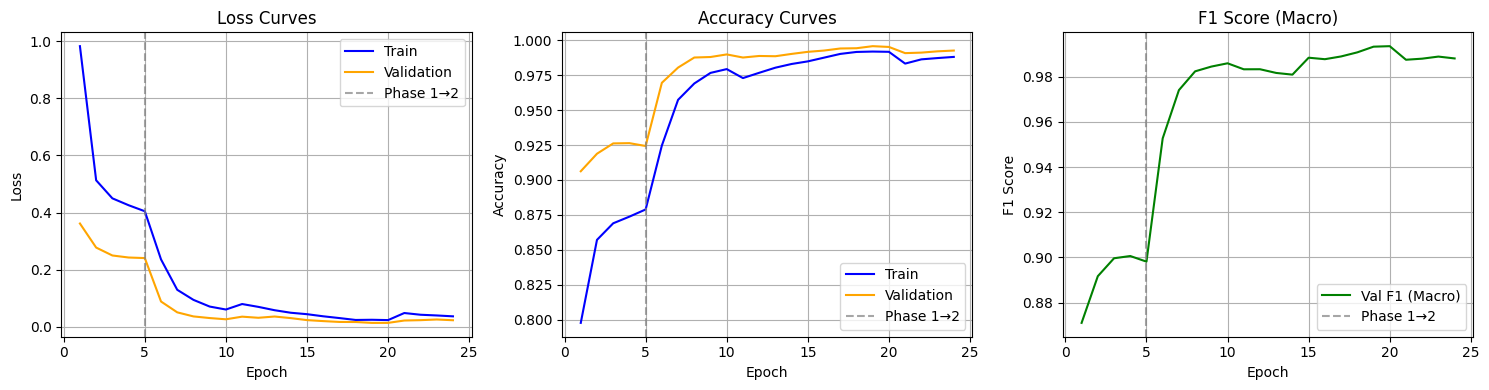

Training curves saved to: d:\Repos\plant-disease-project\models_exported\efficientnet_training_curves.png


In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = range(1, len(history['train_loss']) + 1)
phase1_epochs = sum(1 for p in history['phase'] if p == 1)

# Loss
axes[0].plot(epochs, history['train_loss'], label='Train', color='blue')
axes[0].plot(epochs, history['val_loss'], label='Validation', color='orange')
axes[0].axvline(x=phase1_epochs, color='gray', linestyle='--', alpha=0.7, label='Phase 1→2')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(epochs, history['train_acc'], label='Train', color='blue')
axes[1].plot(epochs, history['val_acc'], label='Validation', color='orange')
axes[1].axvline(x=phase1_epochs, color='gray', linestyle='--', alpha=0.7, label='Phase 1→2')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curves')
axes[1].legend()
axes[1].grid(True)

# F1 Score
axes[2].plot(epochs, history['val_f1'], label='Val F1 (Macro)', color='green')
axes[2].axvline(x=phase1_epochs, color='gray', linestyle='--', alpha=0.7, label='Phase 1→2')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score (Macro)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(config.CHECKPOINT_DIR / 'efficientnet_training_curves.png', dpi=150)
plt.show()

print(f"Training curves saved to: {config.CHECKPOINT_DIR / 'efficientnet_training_curves.png'}")

## 7. Save Final Model

In [15]:
# Save final model
save_checkpoint(
    model, optimizer_phase2, epoch, val_metrics['accuracy'],
    config.CHECKPOINT_DIR / 'efficientnet_final.pth',
    extra_info={
        'class_names': class_names,
        'config': {
            'num_classes': config.NUM_CLASSES,
            'dropout': config.DROPOUT,
            'image_size': config.IMAGE_SIZE
        }
    }
)

print(f"Final model saved to: {config.CHECKPOINT_DIR / 'efficientnet_final.pth'}")

Final model saved to: d:\Repos\plant-disease-project\models_exported\efficientnet_final.pth


In [16]:
# Close TensorBoard logger
logger.close()

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"Best Validation Accuracy: {best_val_acc_phase2:.4f}")
print(f"\nTo view TensorBoard logs, run:")
print(f"  tensorboard --logdir {config.LOG_DIR}")


TRAINING COMPLETE!
Best Validation Accuracy: 0.9958

To view TensorBoard logs, run:
  tensorboard --logdir d:\Repos\plant-disease-project\runs\efficientnet


## 8. Quick Evaluation on Validation Set

In [17]:
# Load best model for evaluation
best_checkpoint = load_checkpoint(
    config.CHECKPOINT_DIR / 'efficientnet_best.pth',
    model
)

print(f"Loaded best model from epoch {best_checkpoint['epoch']}")
print(f"Best validation accuracy: {best_checkpoint['best_metric']:.4f}")

Loaded best model from epoch 19
Best validation accuracy: 0.9958


In [18]:
# Final evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Final Evaluation"):
        inputs = inputs.to(config.DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate final metrics
final_metrics = metrics_calculator.calculate(
    np.array(all_labels),
    np.array(all_preds)
)

print("\nFinal Validation Metrics:")
print(f"  Accuracy: {final_metrics['accuracy']:.4f}")
print(f"  F1 (Macro): {final_metrics['f1_macro']:.4f}")
print(f"  F1 (Weighted): {final_metrics['f1_weighted']:.4f}")

Final Evaluation:   0%|          | 0/170 [00:09<?, ?it/s]


Final Validation Metrics:
  Accuracy: 0.9958
  F1 (Macro): 0.9933
  F1 (Weighted): 0.9958


In [19]:
# Display per-class F1 scores (top 10 worst performing)
import pandas as pd

f1_scores = final_metrics['f1_per_class']
class_f1_df = pd.DataFrame({
    'Class': class_names,
    'F1 Score': f1_scores
}).sort_values('F1 Score')

print("\nTop 10 Worst Performing Classes:")
print(class_f1_df.head(10).to_string(index=False))


Top 10 Worst Performing Classes:
                                             Class  F1 Score
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot  0.925926
               Corn_(maize)___Northern_Leaf_Blight  0.963351
                                  Potato___healthy  0.967742
                             Tomato___Early_blight  0.974874
                              Tomato___Late_blight  0.984211
                              Potato___Late_blight  0.984925
                              Tomato___Target_Spot  0.989170
                       Tomato___Septoria_leaf_spot  0.991597
                                Apple___Apple_scab  0.992000
                                  Tomato___healthy  0.993750
